<a href="https://www.kaggle.com/code/laxmivatsalyadaita/cafe-review-sentiment-analysis?scriptVersionId=141309112" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**If you like my notebook, please don't forget to UPVOTE! You can also make a copy of my notebook and edit to run your additional analysis.**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/zomato-cafe-reviews/reviews.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Importing the Dataset

In [3]:
data = pd.read_csv('/kaggle/input/zomato-cafe-reviews/reviews.csv')
data.head()

,Index,Name,Overall_Rating,Cuisine,Rate for two,City,Review
0,0,Oliver Brown,3.9,"Cafe, Coffee, Shake, Juices, Beverages, Waffle...",500,ahmedabad,Been to this place 3-4 times. Prakash is alway...
1,1,Oliver Brown,3.9,"Cafe, Coffee, Shake, Juices, Beverages, Waffle...",500,ahmedabad,I recently visited Oliver Brown on a weekend f...
2,2,Crush Coffee,3,"Cafe, Shake, Beverages, Desserts",600,ahmedabad,Very watery ans thin shake
3,3,The Mohalla,3.8,Cafe,550,ahmedabad,it was not cheese burst pizza.. only cheeze wa...
4,4,The Mohalla,3.8,Cafe,550,ahmedabad,"Yammi.,....test burger is best I love 💗 this B..."


In [4]:
data['Overall_Rating'].unique()

array(['3.9', '3', '3.8', '4.3', '3.7', '4.8', '4.1', '4', '4.2', '3.6',
       '4.4', '-', '3.5', '3.4', '3.1', '3.3', '3.2', '4.5', '4.9', 'New',
       '2.8', '2.7', '2.5', '2.9', '2.6'], dtype=object)

In [5]:
data = data[data['Overall_Rating']!='-']

In [6]:
data = data[data['Overall_Rating']!='New']

In [7]:
data.shape

(658, 7)

# Exploratory Data Analysis

Plotting overall ratings:

In [8]:
fig = px.histogram(data, x="Overall_Rating")
fig.update_layout(title_text='Overall_Rating')
fig.show()

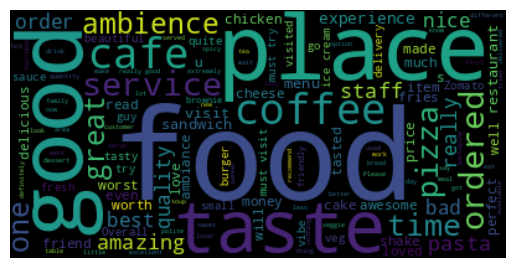

In [9]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["br", "href"])
textt = " ".join(review for review in data.Review)
wordcloud = WordCloud(stopwords=stopwords).generate(textt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud.png')
plt.show()

In [10]:
data['Overall_Rating'] = pd.to_numeric(data['Overall_Rating'], errors='coerce')

In [11]:
data['sentiment'] = data['Overall_Rating'].apply(lambda x: 1 if x > 3 else -1)

In [12]:
positive = data[data['sentiment'] == 1]
negative = data[data['sentiment'] == -1]

In [13]:
data['sentimentt'] = data['sentiment'].replace({-1 : 'negative'})
data['sentimentt'] = data['sentimentt'].replace({1 : 'positive'})
fig = px.histogram(data, x="sentimentt")
#fig.update_traces(marker_color="yellow",marker_line_color='rgb(8,48,107)',
                 # marker_line_width=1.5)
fig.update_layout(title_text='Review sentiment')
fig.show()

# Data Cleaning

In [14]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"','food','Food'))
    return final

data['Review'] = data['Review'].apply(remove_punctuation)
data['Cuisine'] = data['Cuisine'].apply(remove_punctuation)

In [15]:
newData = data[['Review','sentiment']]
newData.head()

,Review,sentiment
0,Been to this place 3-4 times Prakash is always...,1
1,I recently visited Oliver Brown on a weekend f...,1
2,Very watery ans thin shake,-1
3,it was not cheese burst pizza only cheeze was ...,1
4,"Yammi,test burger is best I love 💗 this Berger...",1


# Splitting the Dataset

In [16]:
index = newData.index
newData['random_number'] = np.random.randn(len(index))
train = newData[newData['random_number'] <= 0.80]
test = newData[newData['random_number'] > 0.20]

/tmp/ipykernel_21/3921325847.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
# count vectorizer:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')

train_matrix = vectorizer.fit_transform(train['Review'])
test_matrix = vectorizer.transform(test['Review'])

In [18]:
x_train = train_matrix
x_test = test_matrix
y_train = train['sentiment']
y_test = test['sentiment']

# Classification Models

**Logistic Regression:**

In [19]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

reg = LogisticRegression()


#fitting the model
reg.fit(x_train,y_train)

#predicting
reg_pred = reg.predict(x_test)

print("accuracy is: ", accuracy_score(y_test,reg_pred))
pd.crosstab(y_test,reg_pred)

accuracy is:  0.9049429657794676


col_0,-1,1
sentiment,,
-1,5,23
1,2,233


In [20]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, reg_pred, target_names=['-1', '1']))


Classification Report

              precision    recall  f1-score   support

          -1       0.71      0.18      0.29        28
           1       0.91      0.99      0.95       235

    accuracy                           0.90       263
   macro avg       0.81      0.59      0.62       263
weighted avg       0.89      0.90      0.88       263



**Naive Bayes Classifier:**

In [21]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(x_train, y_train)
mnb_pred = mnb.predict(x_test)
print('\nClassification Report\n')
print(classification_report(y_test, mnb_pred, target_names=['-1', '1']))


Classification Report

              precision    recall  f1-score   support

          -1       1.00      0.04      0.07        28
           1       0.90      1.00      0.95       235

    accuracy                           0.90       263
   macro avg       0.95      0.52      0.51       263
weighted avg       0.91      0.90      0.85       263



**SVM:**

In [22]:
from sklearn.svm import SVC

svm = SVC(kernel="rbf", gamma=0.5, C=1.0)
svm.fit(x_train, y_train)

SVC(gamma=0.5)

In [23]:
svm_pred = svm.predict(x_test)
print('\nClassification Report\n')
print(classification_report(y_test, mnb_pred, target_names=['-1', '1']))


Classification Report

              precision    recall  f1-score   support

          -1       1.00      0.04      0.07        28
           1       0.90      1.00      0.95       235

    accuracy                           0.90       263
   macro avg       0.95      0.52      0.51       263
weighted avg       0.91      0.90      0.85       263



**Random Forest Classifier:**

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_train, y_train)

rf_pred = rf.predict(x_test)
pd.crosstab(y_test,rf_pred)

col_0,-1,1
sentiment,,
-1,8,20
1,0,235


In [25]:
print('\nClassification Report\n')
print(classification_report(y_test, rf_pred, target_names=['-1', '1']))


Classification Report

              precision    recall  f1-score   support

          -1       1.00      0.29      0.44        28
           1       0.92      1.00      0.96       235

    accuracy                           0.92       263
   macro avg       0.96      0.64      0.70       263
weighted avg       0.93      0.92      0.90       263



**K-NN Classifier:**

In [26]:
from sklearn.neighbors import KNeighborsClassifier

k_range = range(1,26)
scores = {}
scores_list = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    scores[k] = accuracy_score(y_test,y_pred)
    scores_list.append(accuracy_score(y_test,y_pred))

Text(0, 0.5, 'Testing accuracy')

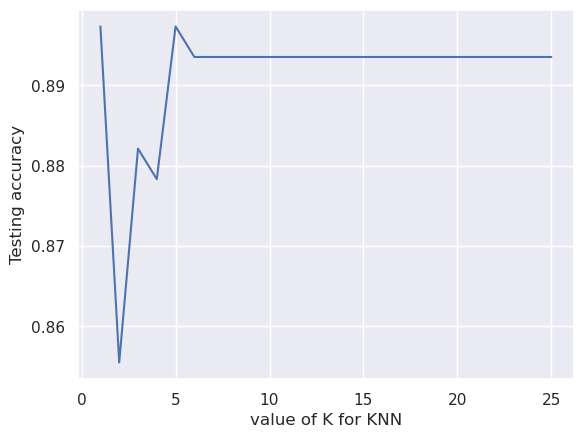

In [27]:
plt.plot(k_range, scores_list)
plt.xlabel('value of K for KNN')
plt.ylabel('Testing accuracy')

conclusion: random forest classifier gave best performance with 83% accuracy.